## REI505M Machine Learning - Homework 1
### Given Sunday 27.8.2023. Due: Monday 4.9.2023

**Objectives**: Pyhton/NumPy practice, Linear regression, Stochastic gradient descent.

**Name**: (your name here), **email: ** (your email here), **collaborators:** (if any)

Please provide your solutions by filling in the appropriate cells in this notebook, creating new cells as needed. Hand in your solution in PDF format on Gradescope. Aim to hand in a fairly clean notebook, avoid including pages upon pages of outputs from "dummy" print statements (use the mod (%) operator to control print/debug statements!)

Make sure that you are familiar with the course rules on collaboration (encouraged) and copying (very, very, bad!)

To get up to speed with Python and NumPy the following may be helpful:

* A tutorial on Python and NumPy from CS231 at Stanford: https://cs231n.github.io/python-numpy-tutorial/

* A tutorial in the form of a Jupyter notebook from CS229 at Stanford: https://cs229.stanford.edu/notes2022fall/cs229-python_review_materials.zip

**Note**: This notebook is long, and finishing the assignment takes some time (start early!) but it is nowhere as bad as it may seem! In many cases the solution is just a few lines of code, in other cases, the solution can be obtained by performing small modifications to examples that can be found on Canvas.

### 1) NumPy warmup [20 points]

In this exercise you will be given code snippets in Python and your task is to vectorize the code, i.e., recast it as matrix/vector operations and implement using NumPy while maintaining its functionality, see the matrix-vector multiplication example below. The functions correspond to frequently used operations in Machine learning algorithms. **Remember to always show the results of executing your code**.

In [1]:
import numpy as np

def matrix_vector_multiplication(A, x):
    # Computes a matrix-vector product
    # Input: A is an n x m matrix
    #        x is an (n,) element vector
    # Output: y = Ax
    n, m = A.shape
    assert(n == x.shape[0])
    y = np.zeros(n, dtype=A.dtype)
    for i in range(n):
        for j in range(m):
            y[i] += A[i,j] * x[j]
    return y

# Test case
A = np.array([[1, 7], [32, -4.5]])
x = np.array([5, 13])
print(matrix_vector_multiplication(A, x)) # Outputs [96., 101.5]

[ 96.  101.5]


An vectorized version uses `numpy.dot` to compute the matrix-vector product

In [2]:
def matrix_vector_multiplication_vectorized(A, x):
    assert(A.shape[0] == x.shape[0])
    return np.dot(A, x)
print(matrix_vector_multiplication_vectorized(A, x)) # Outputs [96., 101.5]

[ 96.  101.5]


We can easily measure the speedup we can from vectorizing the above code. The results vary between runs but the speedup on a MacBook Pro is more than 2000-fold.

In [3]:
n = 1000
A = np.random.rand(n, n)
x = np.random.rand(n)

%timeit matrix_vector_multiplication(A, x)
%timeit matrix_vector_multiplication_vectorized(A, x)

222 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
109 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Note: A frequent source of frustration when learning NumPy is that $n$-element vectors can be represented as 1D arrays of dimension (n,) and also as 2D arrays of dimension n x 1. The `numpy.reshape` command can be used to go from one representation to the other.

In [4]:
a = np.ones((5,))
print(a.shape) # (5,)
b = np.ones((5, 1))
print(b.shape) # (5, 1)

print((a.reshape(5,1)).shape) # (5,1)

(5,)
(5, 1)
(5, 1)


**a) [5 points]** Implement code that takes two 1D arrays of the same length as input and sums the product of all the pairs.

In [5]:
def sumproducts(x, y):
    assert(x.shape[0] == y.shape[0])
    s = 0
    for i in range(x.shape[0]):
        s += x[i] * y[i]
    return s

x = np.array([1, 2, 3, 4])
y = np.array([9, 8, 7, 6])
print(sumproducts(x, y)) # Outputs 70

70


In [6]:
def sumproducts_vectorized(x, y):
    assert(x.shape[0] == y.shape[0])
    return np.dot(x, y)

print(sumproducts_vectorized(x, y)) # Outputs 70

70


**b) [5 points]** Implement code that takes a 2D array and applies the ReLU function on all the values in the array. The ReLU function is defined as $f(x) = \max(0, x)$.

In [23]:
def ReLU(A):
    n, m = A.shape
    B = np.zeros_like(A)
    for i in range(n):
        for j in range(m):
            B[i,j] = np.maximum(0, A[i,j])
    return B

A = np.array([[-4, 4.5, 3], [1, -2, -3]])
print(ReLU(A)) # Outputs [[0., 4.5, 3.], [1., 0., 0.]]

[[0.  4.5 3. ]
 [1.  0.  0. ]]


In [26]:
def ReLU_vectorized(A):
    return np.maximum(0,A)

print(ReLU_vectorized(A)) # Outputs [[0., 4.5, 3.], [1., 0., 0.]]

[[0.  4.5 3. ]
 [1.  0.  0. ]]


**c)  [5 points]** Implement vectorized code that computes the Euclidean distance between two 2D arrays of dimensions $(n,m)$,
$$
d(A, B) = \sqrt{\sum_{i=1}^n \sum_{j=1}^m \left((A_{ij} - B_{ij})^2\right)}.
$$

In [28]:
def matrix_distance(A, B):
    n, m = A.shape
    d = 0
    for i in range(n):
        for j in range(m):
            d += (A[i][j] - B[i][j])**2
    return np.sqrt(d)
    
A = np.array([[1, 2, 3],[4, 5, 6]])
B = np.array([[1,-2, 4],[10, 11, 12]])
print(matrix_distance(A, B)) # Output 11.18

11.180339887498949


In [30]:
def matrix_distance_vectorized(A,B):
    return np.linalg.norm(A - B)
    

print(matrix_distance_vectorized(A, B)) # Output 11.18

11.180339887498949


**d) [5 points]** We test the code further by computing the Euclidean distance between grayscale images from a subset of the (ancient) Yale face database. In particular, we have two images for each of two subjects, and will calculate both intra-subject and inter-subject distance between the images. Early facial recognition algorithms were based on similar approaches but they have now been replaced by neural networks.

An image is represented by a matrix where element (i,j) is the intensity of pixel (i,j), a value of zero is black, and 1.0 is white. The numbers in the figure below represent distance between image pairs.

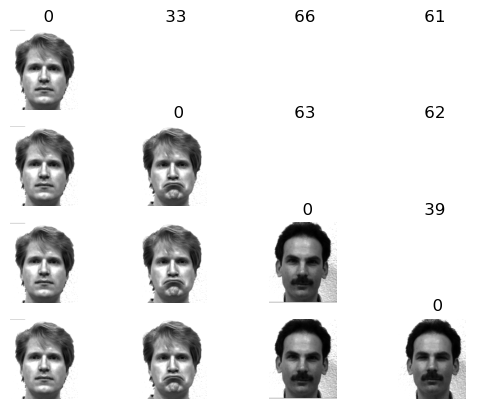

In [31]:
import matplotlib.pyplot as plt

subjects = [1, 2]
expressions = ['normal','sad']

height, width = 231, 195

# Store all images in a 3D array of dimensions num_images x width x height
num_images = len(subjects) * len(expressions)
A = np.zeros((num_images, height, width))

# Read images from PGM files
lookup = {} # For easy image lookup
idx = 0
for subject in subjects:
    for expression in expressions:
        # The images are stored as uint8 (8-bit unsigned integers)
        # Convert to float to avoid floating point overflows downstream
        A[idx,:,:] = plt.imread(f'data/subject{subject:02d}.{expression}.pgm') / 255.0
        lookup[(subject, expression)] = idx
        idx += 1
plt.show()

# Compute pairwise distances (symmetric num_images x num_images matrix)
B = np.zeros((num_images, num_images))
for i in range(num_images):
    for j in range(num_images):
        B[i,j] = matrix_distance_vectorized(A[i,:,:], A[j,:,:])

# Display images and pairwise distances        
plot_idx = 0
for i in range(num_images):
    image_idx = 0
    for j in range(0, num_images):
        plt.subplot(num_images, num_images, plot_idx + 1)
        if j <= i:
            plt.imshow(A[image_idx,:,:],cmap='gray')
            image_idx += 1
        plt.axis('off')
        if j >= i:
            plt.title(f'{B[i,j]:3.0f}')
        plot_idx += 1
plt.show()

Your Boss, Mr. Burns, asks you implement a facial recognition system from scratch. He is too stingy to use a commercial system and he doesn't trust open source software ("what kind of idiot gives out software for free?"). Having taken some linear algebra class during his Nuclear engineering studies, Mr. Burns intructs you to use the Euclidean distance to match an image $x$ of an employee entering the Power Plant with a database of facial images, $z_1, \ldots, z_N$ of all the employees (including the employee in question) by returning the image $z_k$ with the smallest distance to $x$. The plan is to later apply a threshold to the distance to decide whether the two images are of the same person.

What can go wrong with this strategy? List 5 or more potential issues.

**Your answer here**:

### 2) An alternative cost function for linear regression [30 points]

The least-squares cost function
$$
    J(\theta) = \frac{1}{2}\sum_{i=1}^n (f_\theta(x^{(i)}) - y^{(i)})^2
$$
is the workhorse of linear regression but it has a significant drawback, namely it is sensitive to 'outliers', data points that differ significantly from the rest. If the prediction, $f_\theta(x^{(i)})$ differes considerably from the true value $y^{(i)}$, the squared difference will have a large contribution to $J(\theta)$, magnifying the effect of outlier points. Using the absolute error $|f_\theta(x^{(i)}) - y^{(i)})|$ instead of the squared error, reduces the effects of outliers but the price to pay is the optimization becomes more difficult.

The *log-cosh* cost function
$$
    J(\theta) = \sum_{i=1}^n \log \cosh (f_\theta(x^{(i)}) - y^{(i)})
$$
alleviates the outlier problem to some extent by behaving like the squred error when the difference between model predictions and data is small but like the absolute error when the difference is large. The log-cosh function is differentiable and can be used in gradient descent algorithms.

*Note 1*: Outliers in data can arise for many reasons, they can e.g. represent faulty measurements or simply be due to high variability in the data. Detecting outliers prior to fitting a machine learning model is in general not trivial. A machine learning algorithm should preferrably be robust to the presence of (few) outliers in the data.

*Note 2*: The hyperbolic cosine is defined as
$$
\cosh(x) = \frac{e^x + e^{-x}}{2}.
$$
For large positive or negative values of $x$ one of the exponentials becomes huge which in turn leads to floating point overflow (this happens for $|x|>700$). Instead of computing the function with `np.log(np.cosh(x))` use the following

```python
   def logcosh_stable(x):
      return np.abs(x) + np.log1p(np.exp(-2 * np.abs(x))) - np.log(2)
```

*Note 3*: The derivative for logcosh is
$$
\frac{d}{dx}(\log \cosh(x)) = \tanh(x).
$$
The implementation of `tanh(x)` in NumPy is numerically stable and can be used as is.

**a) [20 points]** Implement the gradient descent algorithm for linear regression that uses the *log-cosh* cost function by building on the code from `week01_gradient_descent`. Your code should keep track of the objective function $J(\theta)$ for each iteration. By plotting a graph of $J(\theta)$ as a function of the iteration number you can identify whether the algorithm is converging and adjust the step size and max number of iterations accordingly.

Test your code on the artificial outlier data set defined below using the model
$$
f_\theta(x)=\theta_0 + \theta_1 x_1
$$
and compare the resulting model with the one you get with least squares regression by creating a scatter plot of the data that includes the two regression lines in the plot (see `week01_gradient_descent`).

In [ ]:
import numpy as np

# Create an 1D artificial data set with an outlier for testing
n = 10
x = np.arange(0, 1, 1/n)
y = 2*x + 0.15*np.random.randn(n)
y[-1] = 10 # Outlier

In [ ]:
def linreg_cosh_gd(X, y, alpha, max_iter):

    Jhist = np.zeros(max_iter) # History of the mean squared error
    
    # INSERT YOUR CODE HERE
    
    return theta, Jhist

# Create data matrix X to account for the intercept term (theta_0)
# INSERT YOUR CODE HERE

# Fit the logcosh regression model to (X,y) and plot J and report theta values
# INSERT YOUR CODE HERE

# Fit a least squares model
# INSERT YOUR CODE HERE

# Compare the two models visually
# INSERT YOUR CODE HERE

What can you conclude from this (single) experiment?

**Your answer here**:

**b) [10 points]** Here you apply the method from a) to a $250 \times 10$ regression data set (taken from Stanford's EE104 course) that has been corrupted in non obvious ways, simulating a real-world scenario with outlier data.

The data is in JSON format and is read into NumPy arrays as follows.

In [ ]:
import codecs, json 

obj_text = codecs.open('data/outlier_rem.json', 'r', encoding='utf-8').read()
obj = json.loads(obj_text)

X_train = np.array(obj['U_train']['data'])
y_train = np.array(obj['v_train']['data'])
X_test = np.array(obj['U_test']['data'])
y_test = np.array(obj['v_test']['data'])

Fit a regression model, without a constant term (intercept),
$$
y = \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_{10} x_{10}
$$
using the log-cosh objective to the corrupted data in (X_train, y_train). Compute model predictions for the values in X_test, $\hat{y} = X_{\text{test}} \theta$ and compute the root-mean-square error (RMSE) between the true values and predictions,
$$
\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n (\hat{y}^{(i)} - y^{(i)})^2}.
$$
Repeat using least squares regression and report the RMSE errors of the two methods.
 
*Note*: The values in (X_test,y_test) were not used to fit the models, hence they provide independent means to assess the quality of the models.

In [ ]:
# INSERT YOUR CODE HERE

Which method performs better?

**Your answer here**:

### 3) Linear regression with stochastic gradient descent, [50 points] 

Here you implement stochastic gradient descent (SGD) for linear least squares regression using only NumPy functionality.

The model is on the form
$$
f_\theta(x)=\theta_0 + \sum_{j=1}^p \theta_j x_j.
$$

The following SGD algorithm was presented in class:

Iterate $k=1,2,\ldots,k_{max}$

> Select $i$ uniformly at random from from $[1,\ldots,n]$
$$
 \theta_j^{(k)} \leftarrow \theta_j^{(k-1)} - \alpha_k \frac{\partial \ell^{(i)} (\theta_j^{(k-1)})}{\partial \theta_j},\qquad j=1,\ldots,p
$$

It turns out that it is more efficient (as in faster convergence) to iterate through the complete data set a number of times such that before each iteration the dataset is reshuffled (randomly permuted). Each pass is called on *epoch* and the number of epochs is a hyperparameter which controls for how long the algorithm is trained (more on this later in the course). You will implement the following strategy below ($n$ denotes the number of examples in the data set)

```python
for epoch = 1 to num_epochs
   idx = random permutation of integers 1...n
   for j = 1 to n
      i = idx[j]
      Update weights using formula above
```
See the gradient descent code in the Jupyter notebook `week01_gradient_descent` on Canvas to get you started.

**a) [30 points]** Fill in the `LinearRegressionSGD` class below by adding code to the `fit` and `predict` functions. The `fit` function computes the coefficients in a linear regression model using SGD and `predict` computes the model predictions. Keep track of the objective function values $J(\theta)$ computed during each epoch. This is necessary for troubleshooting the training procedure.

Plot $J(\theta)$ as a function of epochs and report the $\theta$-values for the given "toy" data set, for hyper-parameters `alpha=0.91` (not a very good value chosen on purpose) and `num_epochs=20`.

*Notes*:

1) Since the data is generated we know the true values - in practice this is never the case.

2) You can use the `linear_reg` dataset used in the `week01_gradient_descent` notebook to get started. Write the $\theta$ values to the screen every epoch (or every 5th or 10th or ...) to monitor convergence.

3) During development you may find it convenient to work with the fit and predict code "directly", before implementing them as class functions. This enables you to focus on the learning algorithm first and dealing with Python class formalities later.

4) You can use e.g., `numpy.random.shuffle` or `numpy.random.permutation` to generate random permutations of integers.

5) (Optional) A discussion on the effects of different randomization strategies on SGD: https://stats.stackexchange.com/questions/242004/why-do-neural-network-researchers-care-about-epochs)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class LinearRegressionSGD(object):
    def __init__(self, include_intercept=True, max_iter=100):
        self.theta = None # Stores model coefficients

    def fit(self, X, y, alpha=0.1, num_epochs=1):
        ''' Fits a linear model using stochastic gradient descent.

        Inputs
        ------
        X : 2D numpy array, shape (n, p), containing the training set
            Each row is an input vector for one example.
        y : 1D numpy array, shape (n,)
            Output measurements for all examples in the train set.
        alpha : Learning rate (a.k.a. step size).
        num_epochs : Number of passes through the training set.
                     The number of SGD weight updates is n*num_epochs.

        Returns an array containing the squared loss for each epoch.

        Post
        ----
        self.theta vector, shape (p,) has been updated.
        '''

        n, p = X.shape
        self.theta = np.zeros(p) # Starting point
        J = np.zeros(num_epochs)
        
        # INSERT YOUR CODE HERE
        
        return J

    def predict(self, X):
        ''' Predict using the linear model.

        Input
        -----
        X : 2D numpy array, shape (n, p) containing the examples of interest.
            Each row is a feature vector for one example.
        
        Output
        ------
        yhat : 1D numpy array, shape (n,) containing the predictions for the inputs.
        '''
        
        # INSERT YOUR CODE HERE
        
        pass # Replace with a return statement
    
# Create a simple 1D data set to test your implementation
n = 50
x = np.linspace(0, 1, n)
y = 2 * x + 5 + 0.75 * np.random.randn(n)

# INSERT YOUR CODE HERE

**Your answer here**:

The value of $\theta$ obtained with SGD:

**b) [10 points]** Find a value of the `alpha` and `num_epochs` parameters that give a better fit and plot the corresponding $J(\theta)$.

In [ ]:
### INSERT YOUR CODE HERE

**c) [10 points]** Now apply the above algorithm to a real world housing dataset. The dataset contains $n=20640$ observations where each observation has $p=8$ features. Fit a model on the form
$$
y = \theta_0 + \theta_1 x_1 + \ldots + \theta_8 x_8
$$
Start by solving the regression problem via the normal equations (`numpy.linalg.lstsq`) to have a point of reference.

**Note**: (Optional): A description of the data set can be found here: https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

In [ ]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

# INSERT CODE HERE

You may have problems finding a learning rate that gives good results (compare to the values obtained via the normal equations). You therefore need to take a closer look at the data, in particular the average of feature values over all the examples

In [ ]:
print(np.mean(X, axis=0))

What do the averages tell you, how is the SGD likely to be affected, and what can be done to remedy it?

**Your answer here**: 